In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize']=(16,9)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Input,Dropout,Conv2D,Conv2DTranspose,UpSampling1D,UpSampling2D,Flatten,Reshape,MaxPooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.regularizers import l2

import pickle
import math

import glob
import os

from music21 import converter, instrument, note, chord, stream

import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfpd
from tensorflow_probability import layers as tfpl


In [2]:
fp = open('ins_convgan_final_fantasy.pkl', "rb")
ins = pickle.load(fp)
fp.close()

In [3]:
fp = open('pitch_dict_convgan_final_fantasy.pkl', "rb")
pitch_dict = pickle.load(fp)
fp.close()

In [4]:
ins.shape

(4734, 96, 96, 4)

In [93]:
class ConvAE():
    
    def __init__(self,ins,ldim,verbose=0):
        
        self.encoder = None
        self.decoder = None
        self.ae = None
        
        self.ldim = ldim
        
        self.ins = ins
        
        self.image_height=ins.shape[1]
        self.image_width=ins.shape[2]
        self.num_channels=ins.shape[3]
        self.pixel_length=float(1/12)
        #offsets in music21 are given in terms of 1/4 of a measure, so a pixel_length of 1/12 is actually 1/48 of a measure
        self.measures_per_image=2
        
        self.input_shape=(self.image_height,self.image_width,self.num_channels)
        
        self.verbose=verbose
        
        self.loss_history = np.empty(0)
        
    def build_model(self,filters,kernelsizes,stride,poolfactor,denselayers,activation='elu',padding='same',droprate=0,l2factor=0,klweight=1e-7):
        
        assert (len(filters)==len(kernelsizes)), 'Number of filters must equal number of kernels'
        assert (padding=='valid' or padding=='same'), 'Padding type must be one of "valid" or "same"'
        assert (droprate>=0. and droprate < 1.), 'Dropout rate must be less than 1'
        assert (l2factor>=0. and l2factor < 1.), 'L2 regularization rate must be less than 1'
        
        encoder = Sequential()
        decoder = Sequential()
        
        encoder.add(Input(shape=self.input_shape))
        
        for i in range(len(filters)):
            if l2factor == 0:
                encoder.add(Conv2D(filters[i],(kernelsizes[i],kernelsizes[i]),strides=stride,padding=padding,activation=activation))
            else:
                encoder.add(Conv2D(filters[i],(kernelsizes[i],kernelsizes[i]),strides=stride,padding=padding,activation=activation,kernel_regularizer=l2(l2factor)))
            
            encoder.add(MaxPooling2D(pool_size=(poolfactor,poolfactor),padding=padding))
        
        encoder.add(Flatten())
        
        for layersize in denselayers:
            
            encoder.add(Dense(layersize,activation=activation))
        
        prior = tfpd.Independent(tfpd.Normal(loc=tf.zeros(self.ldim),scale=1),reinterpreted_batch_ndims=1)
        
        encoder.add(Dense(tfpl.IndependentNormal.params_size(self.ldim)))
        encoder.add(tfpl.IndependentNormal(self.ldim,activity_regularizer=tfpl.KLDivergenceRegularizer(prior,weight=klweight)))
        
        self.encoder = encoder
        
        decoder.add(Input(shape=(self.ldim,)))
        
        for layersize in denselayers[::-1]:
            
            decoder.add(Dense(layersize,activation=activation))
            
        decoder.add(Dense(encoder.layers[len(filters)*2].output.shape[1],activation=activation))
        
        decoder.add(Reshape(encoder.layers[len(filters)*2-1].output.shape[1:]))
        
        for i in range(len(filters)-1):
            
            decoder.add(UpSampling2D(size=(poolfactor,poolfactor)))
            
            decoder.add(Conv2DTranspose(filters[-i-2],kernelsizes[-i-1],strides=stride,padding=padding,activation=activation,bias_regularizer=l2(l2factor*10)))
            
        decoder.add(UpSampling2D(size=(poolfactor,poolfactor)))
        
        decoder.add(Conv2DTranspose(self.num_channels,kernelsizes[0],strides=stride,padding=padding,activation='sigmoid',bias_regularizer=l2(l2factor*10)))
        
        self.decoder = decoder
        
        self.ae = Model(inputs=self.encoder.inputs,outputs=self.decoder(self.encoder.outputs[0]))
        
        if self.verbose > 0:
            print(self.encoder.summary(),self.decoder.summary())
            
    def train_model(self,epochs,batch_size,lrate,use_early_stopping=False,patience=0):
        
        self.ae.compile(optimizer=tf.optimizers.Adam(lrate),loss='mse')
        
        if use_early_stopping:
            
            callback1 = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0,patience=patience,restore_best_weights=True)
            
            history1 = self.ae.fit(ins,ins,epochs=epochs,batch_size=batch_size,callbacks=[callback1],use_multiprocessing=True,verbose=self.verbose)
        
        else:
            history1 = self.ae.fit(ins,ins,epochs=epochs,batch_size=batch_size,use_multiprocessing=True,verbose=self.verbose)
            
        self.loss_history = np.concatenate((self.loss_history,history1.history['loss']))
        
        return history1;
        
    def generate_random_images(self,number):
        
        random_seeds = np.random.randn(number,self.ldim)
        
        return self.decoder.predict(random_seeds);
        
    def generate_images_from_tensor(self,seed):
        
        assert (seed.shape[1] == self.ldim), 'Input tensor must have dimension %s'%self.ldim
        
        return self.decocder.predict(seed);
        

In [94]:
tryingclass = ConvAE(ins,100,0)

tryingclass.build_model([12,18],[5,5],2,2,[256],activation='elu',padding='same',l2factor=1e-3)

In [105]:
tryingclass.train_model(100,64,1e-5,use_early_stopping=True,patience=35)

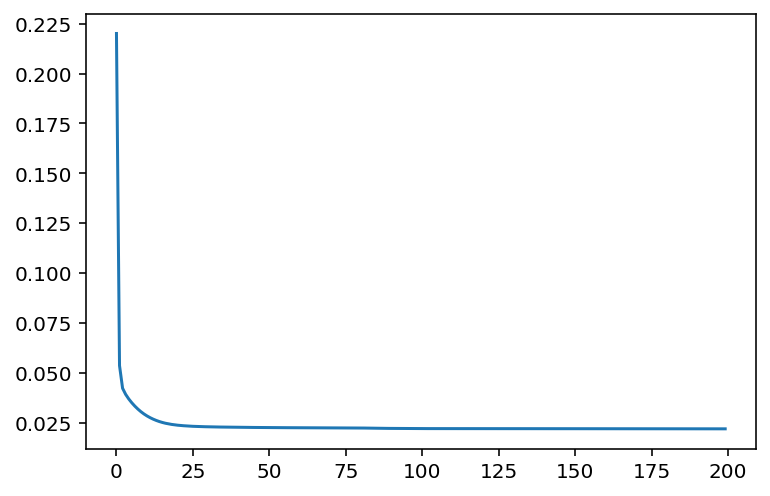

In [106]:
plt.plot(tryingclass.loss_history)

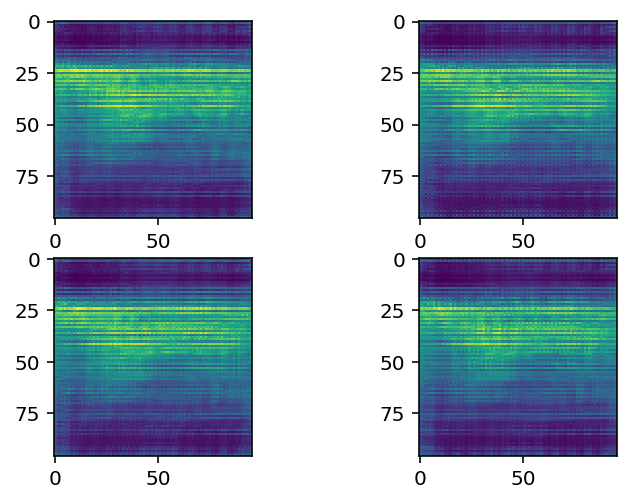

In [107]:
synthim=tryingclass.generate_random_images(1)[0]

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.imshow(synthim[:,:,i])

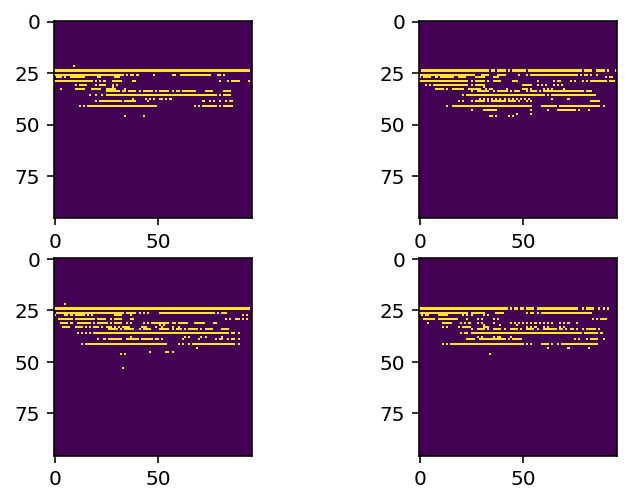

In [108]:
approx1 = np.round(synthim,0)

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.imshow(approx1[:,:,i])

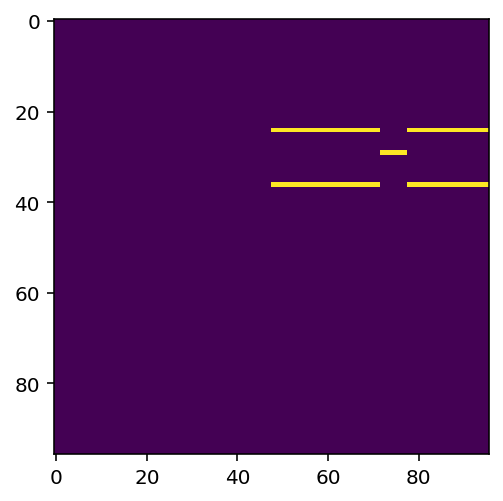

In [101]:
plt.imshow(ins[0][:,:,0])